In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [ ]:
df = pd.read_csv('drive/My Drive/Kidney/kidney_disease.csv')

In [ ]:
# Map text to 1/0 and do some cleaning
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

In [ ]:
# Further cleaning
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
df.drop('id',axis=1,inplace=True)

In [ ]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
df2 = df.dropna(axis=0)
df2['class'].value_counts()

0.0    115
1.0     43
Name: class, dtype: int64

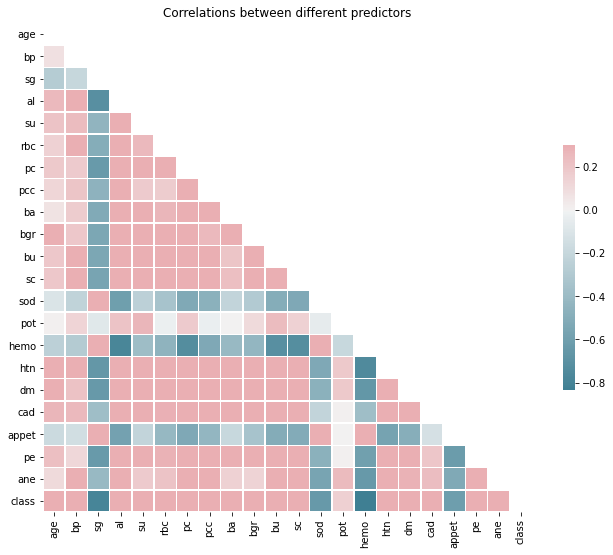

In [ ]:
corr_df = df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['class'], 
                                                    test_size = 0.33, random_state=84,
                                                   stratify= df2['class'] )

In [ ]:
print(X_train.shape)
print(X_test.shape)

(105, 24)
(53, 24)


In [ ]:
y_train.value_counts()

0.0    76
1.0    29
Name: class, dtype: int64

Detailed classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        39
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Confusion Matrix:
[[39  0]
 [ 0 14]]


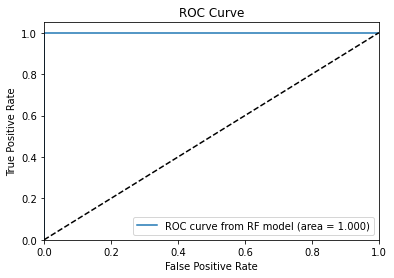

Best parameters:
{'class_weight': None, 'max_depth': 2, 'n_estimators': 8, 'random_state': 82}


In [ ]:
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[82]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
clf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_

Text(0.5, 1.0, 'Feature Importance')

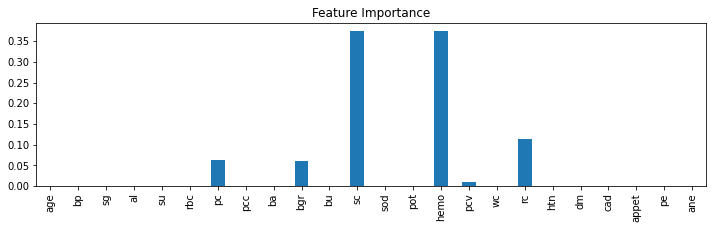

In [ ]:
plt.figure(figsize=(12,3))
features = X_test.columns.values.tolist()
importance = clf_best.feature_importances_.tolist()
feature_series = pd.Series(data=importance,index=features)
feature_series.plot.bar()
plt.title('Feature Importance')

In [ ]:
list_to_fill = X_test.columns[feature_series>0]
print(list_to_fill)

Index(['pc', 'bgr', 'sc', 'hemo', 'pcv', 'rc'], dtype='object')


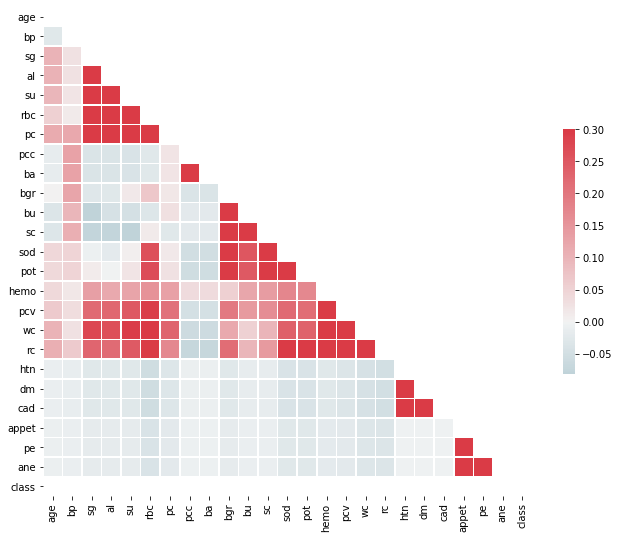

In [ ]:
# Are there correlation in missing values?
corr_df = pd.isnull(df).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78        35
         1.0       0.97      0.94      0.96       207

    accuracy                           0.93       242
   macro avg       0.84      0.90      0.87       242
weighted avg       0.94      0.93      0.93       242

Confusion Matrix:
[[ 30   5]
 [ 12 195]]
Accuracy: 0.929752


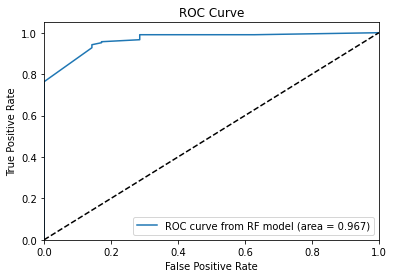

In [ ]:
df2 = df.dropna(axis=0)
no_na = df2.index.tolist()
some_na = df.drop(no_na).apply(lambda x: pd.to_numeric(x,errors='coerce'))
some_na = some_na.fillna(0) # Fill up all Nan by zero.

X_test = some_na.iloc[:,:-1]
y_test = some_na['class']
y_true = y_test
lr_pred = clf_best.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_best, X_test, y_test, 'RF')